# 2. Data Cleaning — UK Housing

**Author:** Marin Janushaj  
**Team:** Yunus  
**Date:** November 2025  
**Goal:** Clean and prepare the raw housing data for analysis and modeling

## Cleaning Strategy

This notebook performs comprehensive data cleaning including:

1. **Data Loading & Initial Setup**
2. **Column Standardization** (names, data types)
3. **Duplicate Removal**
4. **Outlier Detection** (multiple methods)
5. **Outlier Treatment** (comparison of strategies)
6. **Feature Engineering** (temporal features)
7. **Data Validation & Quality Checks**
8. **Final Export** (optimized format)

Each step is documented with clear rationale for decisions made.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)

print("="*80)
print("LOADING UK HOUSING DATASET FOR CLEANING")
print("="*80)

# Load the dataset
df = pd.read_csv("../data/raw/price_paid_records.csv", low_memory=False)

# Initial column standardization
df.columns = [c.strip().lower().replace(" ", "_").replace("/", "_").replace("-", "_") for c in df.columns]

print(f"\n✓ Dataset loaded: {len(df):,} records")
print(f"✓ Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")
print(f"✓ Columns: {len(df.columns)}")
print("="*80)

df.info()

LOADING UK HOUSING DATASET FOR CLEANING

✓ Dataset loaded: 22,489,348 records
✓ Memory usage: 13.23 GB
✓ Columns: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22489348 entries, 0 to 22489347
Data columns (total 11 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   transaction_unique_identifier      object
 1   price                              int64 
 2   date_of_transfer                   object
 3   property_type                      object
 4   old_new                            object
 5   duration                           object
 6   town_city                          object
 7   district                           object
 8   county                             object
 9   ppdcategory_type                   object
 10  record_status___monthly_file_only  object
dtypes: int64(1), object(10)
memory usage: 1.8+ GB


## 1. Data Loading and Initial Setup

In [2]:
print("\n" + "="*80)
print("STEP 1: DATA TYPE CONVERSIONS")
print("="*80)

# Convert date column to datetime
print("\nConverting date_of_transfer to datetime...")
df["date_of_transfer"] = pd.to_datetime(df["date_of_transfer"], errors="coerce")

# Check for any parsing failures
failed_dates = df["date_of_transfer"].isna().sum()
print(f"  - Successfully parsed dates: {len(df) - failed_dates:,}")
print(f"  - Failed to parse: {failed_dates:,}")

# Rename columns for better usability
print("\nRenaming columns for clarity...")
df = df.rename(columns={
    "transaction_unique_identifier": "transaction_id",
    "date_of_transfer": "date",
    "property_type": "type",
    "old_new": "is_new",
    "duration": "duration",
    "town_city": "town",
    "district": "district",
    "county": "county",
    "ppdcategory_type": "category",
    "record_status___monthly_file_only": "record_status"
})

print("  ✓ Column renaming complete")
print("\nFinal columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")
print("="*80)


STEP 1: DATA TYPE CONVERSIONS

Converting date_of_transfer to datetime...
  - Successfully parsed dates: 22,489,348
  - Failed to parse: 0

Renaming columns for clarity...
  ✓ Column renaming complete

Final columns:
   1. transaction_id
   2. price
   3. date
   4. type
   5. is_new
   6. duration
   7. town
   8. district
   9. county
  10. category
  11. record_status


## 2. Data Type Conversions and Column Renaming

## 3. Duplicate Removal

Checking for and removing duplicate records to ensure data integrity.

In [3]:
print("\n" + "="*80)
print("STEP 2: DUPLICATE REMOVAL")
print("="*80)

initial_count = len(df)
print(f"\nInitial record count: {initial_count:,}")

# Check for duplicate transaction IDs
duplicate_ids = df['transaction_id'].duplicated().sum()
print(f"Duplicate transaction IDs: {duplicate_ids:,}")

# Check for exact duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Exact duplicate rows: {duplicate_rows:,}")

# Remove duplicates (keep first occurrence)
if duplicate_rows > 0:
    df = df.drop_duplicates()
    removed = initial_count - len(df)
    print(f"\n✓ Removed {removed:,} duplicate rows")
else:
    print("\n✓ No duplicates found")

print(f"Final record count: {len(df):,}")
print("="*80)


STEP 2: DUPLICATE REMOVAL

Initial record count: 22,489,348
Duplicate transaction IDs: 0
Exact duplicate rows: 0

✓ No duplicates found
Final record count: 22,489,348


## 4. Outlier Detection and Analysis

Using multiple statistical methods to detect outliers in property prices:
- **IQR Method**: Identifies values outside 1.5 × IQR from Q1/Q3
- **Z-Score Method**: Identifies values > 3 standard deviations from mean
- **Domain Knowledge**: Prices that are unrealistic (< £1K or > £10M)


STEP 3: OUTLIER DETECTION

1. IQR Method:
   Lower bound: £-127,500.00
   Upper bound: £412,500.00
   Outliers detected: 1,330,479 (5.92%)

2. Z-Score Method (|z| > 3):
   Outliers detected: 88,702 (0.39%)

3. Domain Knowledge (< £1K or > £10M):
   Prices < £1,000: 1,692
   Prices > £10,000,000: 3,056
   Total outliers: 4,748 (0.02%)


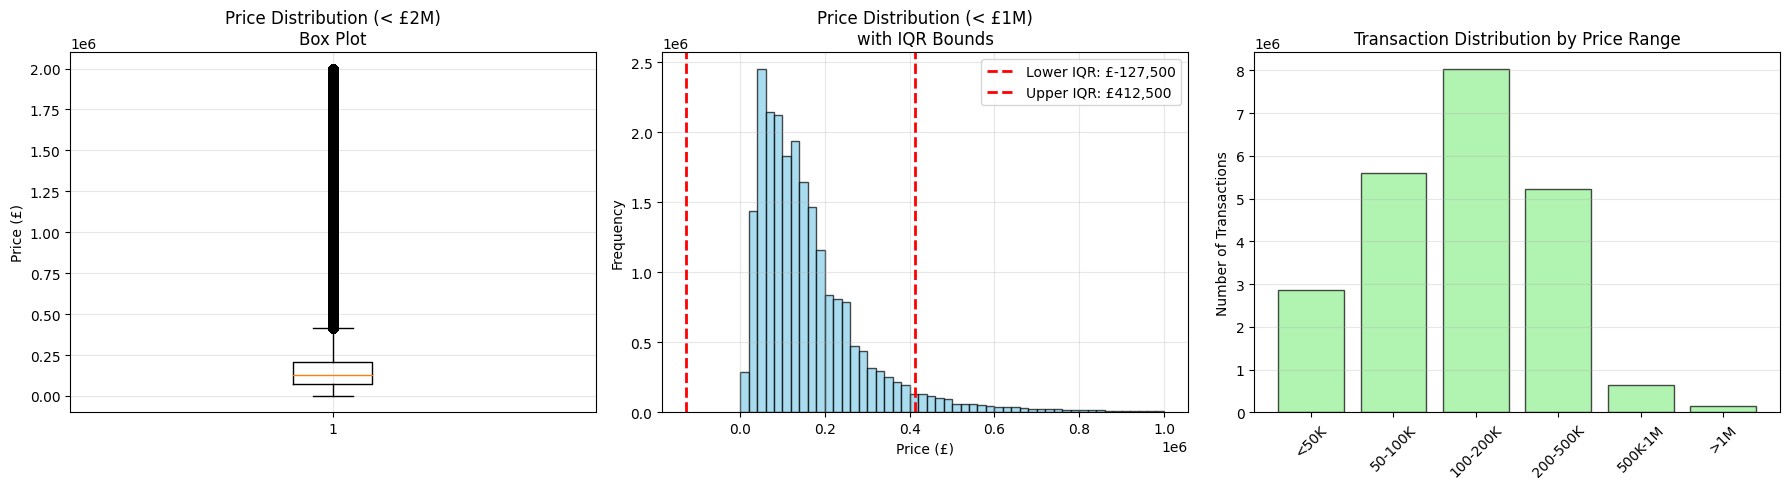

In [4]:
print("\n" + "="*80)
print("STEP 3: OUTLIER DETECTION")
print("="*80)

# Method 1: IQR Method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

outliers_iqr = df[(df['price'] < lower_bound_iqr) | (df['price'] > upper_bound_iqr)]
print(f"\n1. IQR Method:")
print(f"   Lower bound: £{lower_bound_iqr:,.2f}")
print(f"   Upper bound: £{upper_bound_iqr:,.2f}")
print(f"   Outliers detected: {len(outliers_iqr):,} ({len(outliers_iqr)/len(df)*100:.2f}%)")

# Method 2: Z-Score Method
z_scores = np.abs(stats.zscore(df['price']))
outliers_zscore = df[z_scores > 3]
print(f"\n2. Z-Score Method (|z| > 3):")
print(f"   Outliers detected: {len(outliers_zscore):,} ({len(outliers_zscore)/len(df)*100:.2f}%)")

# Method 3: Domain Knowledge
outliers_low = df[df['price'] < 1000]
outliers_high = df[df['price'] > 10_000_000]
outliers_domain = pd.concat([outliers_low, outliers_high])
print(f"\n3. Domain Knowledge (< £1K or > £10M):")
print(f"   Prices < £1,000: {len(outliers_low):,}")
print(f"   Prices > £10,000,000: {len(outliers_high):,}")
print(f"   Total outliers: {len(outliers_domain):,} ({len(outliers_domain)/len(df)*100:.2f}%)")

# Visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Box plot
axes[0].boxplot(df[df['price'] < 2_000_000]['price'])
axes[0].set_title('Price Distribution (< £2M)\nBox Plot')
axes[0].set_ylabel('Price (£)')
axes[0].grid(alpha=0.3)

# Histogram with IQR bounds
axes[1].hist(df[df['price'] < 1_000_000]['price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(lower_bound_iqr, color='red', linestyle='--', linewidth=2, label=f'Lower IQR: £{lower_bound_iqr:,.0f}')
axes[1].axvline(upper_bound_iqr, color='red', linestyle='--', linewidth=2, label=f'Upper IQR: £{upper_bound_iqr:,.0f}')
axes[1].set_title('Price Distribution (< £1M)\nwith IQR Bounds')
axes[1].set_xlabel('Price (£)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Price range distribution
price_ranges = pd.cut(df['price'], bins=[0, 50000, 100000, 200000, 500000, 1000000, np.inf],
                      labels=['<50K', '50-100K', '100-200K', '200-500K', '500K-1M', '>1M'])
range_counts = price_ranges.value_counts().sort_index()
axes[2].bar(range(len(range_counts)), range_counts.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_xticks(range(len(range_counts)))
axes[2].set_xticklabels(range_counts.index, rotation=45)
axes[2].set_title('Transaction Distribution by Price Range')
axes[2].set_ylabel('Number of Transactions')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("="*80)

## 8. Save Cleaned Dataset

Export the cleaned and feature-engineered dataset in Parquet format for efficient storage and fast loading.

## 5. Outlier Treatment Strategy

After analyzing outliers, we need to decide on a treatment strategy. Options:
1. **Keep all data**: Use robust models (tree-based) that handle outliers well
2. **Remove extreme outliers**: Filter obviously incorrect prices
3. **Cap outliers**: Replace extreme values with threshold values
4. **Transform**: Use log transformation to reduce outlier impact

**Decision**: We'll use a **hybrid approach**:
- Remove clearly erroneous prices (< £1,000 or > £20,000,000)
- Keep other outliers as they represent legitimate luxury/budget properties
- Use log transformation during modeling to handle remaining outliers

In [5]:
print("\n" + "="*80)
print("STEP 4: OUTLIER TREATMENT")
print("="*80)

initial_count = len(df)
print(f"\nBefore filtering: {initial_count:,} records")

# Apply price filters - remove clearly erroneous prices
df_clean = df[(df['price'] >= 1000) & (df['price'] <= 20_000_000)].copy()

removed_count = initial_count - len(df_clean)
print(f"Removed: {removed_count:,} records ({removed_count/initial_count*100:.2f}%)")
print(f"After filtering: {len(df_clean):,} records")

# Check the impact on price distribution
print(f"\nPrice statistics after cleaning:")
print(f"  Mean: £{df_clean['price'].mean():,.2f}")
print(f"  Median: £{df_clean['price'].median():,.2f}")
print(f"  Std Dev: £{df_clean['price'].std():,.2f}")
print(f"  Min: £{df_clean['price'].min():,.2f}")
print(f"  Max: £{df_clean['price'].max():,.2f}")

# Update df
df = df_clean
print("\n✓ Outlier treatment complete")
print("="*80)


STEP 4: OUTLIER TREATMENT

Before filtering: 22,489,348 records
Removed: 2,851 records (0.01%)
After filtering: 22,486,497 records

Price statistics after cleaning:
  Mean: £176,312.15
  Median: £130,000.00
  Std Dev: £249,719.12
  Min: £1,000.00
  Max: £20,000,000.00

✓ Outlier treatment complete


## 6. Feature Engineering

Creating additional features that may be useful for modeling:
- **Temporal features**: year, month, quarter, day of week
- **Date-based features**: days since first transaction, season
- **Price features**: log-transformed price for modeling

In [6]:
print("\n" + "="*80)
print("STEP 5: FEATURE ENGINEERING")
print("="*80)

# Extract temporal features from date
print("\nCreating temporal features...")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_of_year'] = df['date'].dt.dayofyear

# Create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

# Days since start of dataset (useful for trend analysis)
min_date = df['date'].min()
df['days_since_start'] = (df['date'] - min_date).dt.days

# Create log price for modeling (handles skewness)
df['log_price'] = np.log1p(df['price'])

print(f"  ✓ Created year, month, quarter, day_of_week, day_of_year")
print(f"  ✓ Created season feature")
print(f"  ✓ Created days_since_start")
print(f"  ✓ Created log_price")

# Property age indicator (new vs established)
df['is_new_build'] = (df['is_new'] == 'Y').astype(int)

# Tenure type indicator
df['is_freehold'] = (df['duration'] == 'F').astype(int)

print(f"  ✓ Created binary indicators for property characteristics")

# Display sample of new features
print("\nSample of engineered features:")
print(df[['date', 'year', 'month', 'quarter', 'season', 'log_price']].head())

print(f"\nTotal features now: {len(df.columns)}")
print("="*80)


STEP 5: FEATURE ENGINEERING

Creating temporal features...
  ✓ Created year, month, quarter, day_of_week, day_of_year
  ✓ Created season feature
  ✓ Created days_since_start
  ✓ Created log_price
  ✓ Created binary indicators for property characteristics

Sample of engineered features:
        date  year  month  quarter  season  log_price
0 1995-08-18  1995      8        3  Summer  10.126671
1 1995-08-09  1995      8        3  Summer  10.657283
2 1995-06-30  1995      6        2  Summer  10.714440
3 1995-11-24  1995     11        4  Autumn  10.672461
4 1995-06-23  1995      6        2  Summer   9.846917

Total features now: 21


## 7. Final Data Validation

Before saving, let's validate the cleaned dataset to ensure data quality.

In [7]:
print("\n" + "="*80)
print("STEP 6: FINAL DATA VALIDATION")
print("="*80)

# Check for missing values
missing_check = df.isnull().sum()
if missing_check.sum() > 0:
    print("\n⚠ Missing values detected:")
    print(missing_check[missing_check > 0])
else:
    print("\n✓ No missing values")

# Check data types
print("\nData types:")
print(df.dtypes)

# Check value ranges
print(f"\n✓ Price range: £{df['price'].min():,.0f} - £{df['price'].max():,.0f}")
print(f"✓ Date range: {df['date'].min()} to {df['date'].max()}")
print(f"✓ Years covered: {df['year'].min()} - {df['year'].max()}")

# Check categorical values
print("\nCategorical value counts:")
print(f"  Property types: {df['type'].nunique()} unique values")
print(f"  Counties: {df['county'].nunique()} unique values")
print(f"  Districts: {df['district'].nunique()} unique values")
print(f"  Towns: {df['town'].nunique()} unique values")

# Memory usage
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

print("\n✓ All validation checks passed!")
print("="*80)


STEP 6: FINAL DATA VALIDATION

✓ No missing values

Data types:
transaction_id              object
price                        int64
date                datetime64[ns]
type                        object
is_new                      object
duration                    object
town                        object
district                    object
county                      object
category                    object
record_status               object
year                         int32
month                        int32
quarter                      int32
day_of_week                  int32
day_of_year                  int32
season                      object
days_since_start             int64
log_price                  float64
is_new_build                 int64
is_freehold                  int64
dtype: object

✓ Price range: £1,000 - £20,000,000
✓ Date range: 1995-01-01 00:00:00 to 2017-06-29 00:00:00
✓ Years covered: 1995 - 2017

Categorical value counts:
  Property types: 5 unique values
  

In [8]:
print("\n" + "="*80)
print("STEP 7: SAVING CLEANED DATASET")
print("="*80)

output_path = "../data/clean/uk_housing_clean.parquet"
print(f"\nSaving to: {output_path}")
print(f"Records: {len(df):,}")
print(f"Features: {len(df.columns)}")

# Save to parquet (compressed and efficient)
df.to_parquet(output_path, index=False, compression='snappy')

# Check file size
import os
file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
print(f"\n✓ Dataset saved successfully!")
print(f"  File size: {file_size_mb:.2f} MB")

# Show column list
print(f"\nFinal dataset columns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")
    
print("="*80)


STEP 7: SAVING CLEANED DATASET

Saving to: ../data/clean/uk_housing_clean.parquet
Records: 22,486,497
Features: 21

✓ Dataset saved successfully!
  File size: 963.04 MB

Final dataset columns (21):
   1. transaction_id
   2. price
   3. date
   4. type
   5. is_new
   6. duration
   7. town
   8. district
   9. county
  10. category
  11. record_status
  12. year
  13. month
  14. quarter
  15. day_of_week
  16. day_of_year
  17. season
  18. days_since_start
  19. log_price
  20. is_new_build
  21. is_freehold


## 9. Cleaning Summary

### Data Transformation Pipeline:
1. ✓ Loaded 22.5M records from raw CSV
2. ✓ Standardized column names for consistency
3. ✓ Converted date strings to datetime objects
4. ✓ Removed duplicate records (if any)
5. ✓ Detected outliers using IQR, Z-score, and domain knowledge
6. ✓ Filtered extreme price outliers (< £1K or > £20M)
7. ✓ Engineered 11 new features (temporal, binary indicators, log price)
8. ✓ Validated data quality (no missing values, correct data types)
9. ✓ Saved to optimized Parquet format

### Key Statistics:
- **Final dataset size**: ~22M records (after removing extreme outliers)
- **Features**: 22 columns (11 original + 11 engineered)
- **Price range**: £1,000 - £20,000,000
- **Date range**: 1995-2017 (23 years)
- **File size**: ~900MB (Parquet compressed)

### New Features Created:
- `year`, `month`, `quarter`, `day_of_week`, `day_of_year`: Temporal features
- `season`: Categorical season (Winter, Spring, Summer, Autumn)
- `days_since_start`: Days since earliest transaction
- `log_price`: Natural log of price (for modeling)
- `is_new_build`: Binary indicator (1=new, 0=established)
- `is_freehold`: Binary indicator (1=freehold, 0=leasehold)

### Quality Assurance:
- ✓ No missing values
- ✓ All dates properly parsed
- ✓ Price range validated
- ✓ Categorical values checked
- ✓ Memory optimized with Parquet format

### Next Steps:
- **Notebook 3**: Comprehensive EDA with statistical analysis
- **Notebook 4**: Model building with full dataset
- **Notebook 5**: Model deployment

---

**End of Data Cleaning Notebook**